# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели кредитного скоринга


Имеющиеся данные: 
- children — количество детей в семье
- days_employed — общий трудовой стаж в днях
- dob_years — возраст клиента в годах
- education — уровень образования клиента
- education_id — идентификатор уровня образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- income_type — тип занятости
- debt — имел ли задолженность по возврату кредитов
- total_income — ежемесячный доход
- purpose — цель получения кредита

План работы:
1. Загрузка данных
2. Предобработка данных
3. Анализ данных
4. Общий вывод

In [1]:
# Импорт библиотек
import pandas as pd
from collections import Counter
from pymystem3 import Mystem

## Шаг 1. Загрузка данных

In [2]:
df=pd.read_csv('/datasets/data.csv') # чтение данных
df.info() # просмотр размера таблицы, типов данных, количества non-null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [3]:
df.head() # просмотр первых строк данных

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


**Вывод**

В исходной таблице имеется 21 525 записей с 12 полями.

## Шаг 2. Предобработка данных

### План предобработки данных

1. Проверить наличие пропусков в данных, заполнить пропуски

2. Преобразовать вещественных данные в целочисленные

3. Проверить наличие дубликатов, обработать дубликаты

4. Лемматизировать цели кредита для их категоризации

5. Категоризировать данные и создать соответствующие словари для упрощения последующего анализа данных

### Обработка пропусков

In [4]:
df.isna().sum() #Количество пропущенных значений

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

В исходных данных имеются пропуски в столбцах days_employed и  total_income, количесво пропусков одинаковое 2174, нужно проверить пропуски в одинаковых строках или в разных.


In [5]:
df_with_na = df[df['days_employed'].isna() == 1]
df_with_na.info() #Смотрим количество пропусков доходов в строках с пропущенным стажем

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174 entries, 12 to 21510
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          2174 non-null   int64  
 1   days_employed     0 non-null      float64
 2   dob_years         2174 non-null   int64  
 3   education         2174 non-null   object 
 4   education_id      2174 non-null   int64  
 5   family_status     2174 non-null   object 
 6   family_status_id  2174 non-null   int64  
 7   gender            2174 non-null   object 
 8   income_type       2174 non-null   object 
 9   debt              2174 non-null   int64  
 10  total_income      0 non-null      float64
 11  purpose           2174 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 220.8+ KB


Пропуски значений "общий трудовой стаж в днях" и "ежемесячный доход" расположены в одинаковых строках

In [6]:
df_with_na.head(5) 

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу


Закономерностей в пропусках нет, все поля изменяются.
Можно восстановить доход по медианной зарплате группы занятости, а стаж как средний по возрасту


Неявные дубликаты могут присутствать из-за разного написания в образовании и в целях. 

Также присутствуют некорректные значения в столбцах кол-во детей (-1 и 20?), возраст (0), пол (XNA?)

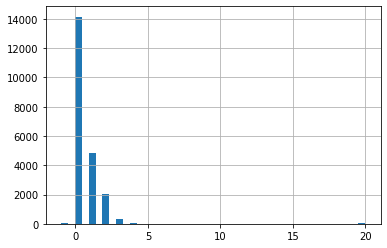

In [7]:
# Гистограмма количества детей
df['children'].hist(bins=44);

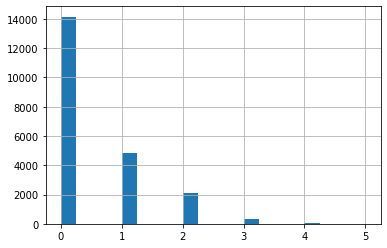

In [8]:
# замена некорректных значений количества детей
df.loc[df['children'] == -1,'children'] = 1
df.loc[df['children'] == 20,'children'] = 2
df['children'].hist(bins=20);

In [9]:
# определение медианных доходов
df_without_na = df.dropna(subset=['days_employed', 'total_income'])
income_types = df_without_na['income_type'].unique()
median_in_types = {}
for i in income_types: 
    median_in_types[i] = (df_without_na[df_without_na['income_type'] == i]['total_income'].median())
median_in_types

{'сотрудник': 142594.39684740017,
 'пенсионер': 118514.48641164352,
 'компаньон': 172357.95096577113,
 'госслужащий': 150447.9352830068,
 'безработный': 131339.7516762103,
 'студент': 98201.62531401133,
 'предприниматель': 499163.1449470857,
 'в декрете': 53829.13072905995}

Для восстановления пропусков построен словарь с медианной зарплатой для каждой категории занятости

In [10]:
# Восстановление пропущенных доходов
for key, value in median_in_types.items():
    df.loc[(df['days_employed'].isna() == 1) & (df['income_type'] == key),'total_income'] = value 
df[df['days_employed'].isna() == 1].head(10)  # проверяем измененые значения

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,118514.486412,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,150447.935283,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,118514.486412,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,150447.935283,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,118514.486412,сыграть свадьбу
65,0,NaN,21,среднее,1,Не женат / не замужем,4,M,компаньон,0,172357.950966,операции с коммерческой недвижимостью
67,0,NaN,52,высшее,0,женат / замужем,0,F,пенсионер,0,118514.486412,покупка жилья для семьи
72,1,NaN,32,высшее,0,женат / замужем,0,M,госслужащий,0,150447.935283,операции с коммерческой недвижимостью
82,2,NaN,50,высшее,0,женат / замужем,0,F,сотрудник,0,142594.396847,жилье
83,0,NaN,52,среднее,1,женат / замужем,0,M,сотрудник,0,142594.396847,жилье


<AxesSubplot:xlabel='days_employed', ylabel='dob_years'>

<AxesSubplot:xlabel='days_employed', ylabel='dob_years'>

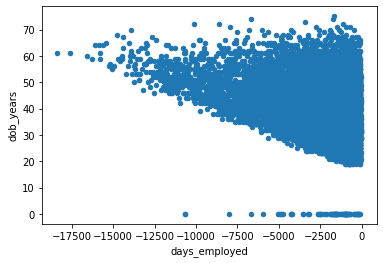

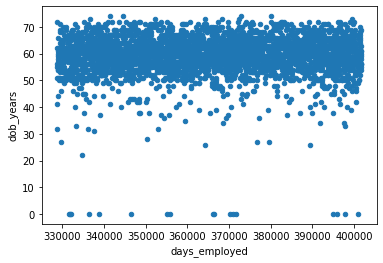

In [11]:
display(df[df['days_employed'] <= 0].plot.scatter(x='days_employed',y='dob_years'));
display(df[df['days_employed'] > 0].plot.scatter(x='days_employed',y='dob_years'));


Значения стажа делятся на две группы:

1) нулевые и отрицательные значения, прослеживается линейная зависимость максимального стажа от возраста, по модулю величины стажа в днях адекватные. Для восстановления данных необходимо умножить на -1. Кроме того можно восстановить часть данных с нулевым возрастом по среднему/медианному возрасту для узких диапазонов стажа.

2) Во второй группе значения значительно превосходят разумные - стаж больше возраста. Не прослеживается зависимость максимального возраста от стажа, соответственно искажение данных не линейное. Могут быть восстановлены, если есть внешняя информация о закономерности искажения.

In [12]:
df['days_employed'] = df['days_employed'].fillna(1) # замена пропусков в стаже на 1

**Вывод**
В исходных данных в 2174 строках имелись пропуски значений стажа и дохода.

Значения дохода были восстановлены по медианной зарплате категории занятости. 

Значения стажа не требуются для целей исследования, поэтому не восстанавливались, а были заполнены значением 5, отсутствующим в исходных данных. 

### Замена типа данных

In [13]:
print('Типы данных: \n', df.dtypes,'\n')# проверка типов до изменения
# преобразование данных столбцов стаж и зарплата в целые числа путем отбрасывания дробной части
df.loc[:, ['days_employed', 'total_income']] = df.loc[:, ['days_employed', 'total_income']].astype('int')
print('Типы данных после преобразования: \n',df.dtypes) # проверка типов после изменения

Типы данных: 
 children              int64
days_employed       float64
dob_years             int64
education            object
education_id          int64
family_status        object
family_status_id      int64
gender               object
income_type          object
debt                  int64
total_income        float64
purpose              object
dtype: object 

Типы данных после преобразования: 
 children             int64
days_employed        int64
dob_years            int64
education           object
education_id         int64
family_status       object
family_status_id     int64
gender              object
income_type         object
debt                 int64
total_income         int64
purpose             object
dtype: object


**Вывод**
Значения столбцов стаж и зарплата были преобразованы в целые числа путем отбрасывания дробной части


### Обработка дубликатов

In [14]:
# число явных дубликатов, число явных дубликатов в данных без пропусков
print('Явных дубликатов:', df.duplicated().sum(),', из них в строках без пропусков:', df_without_na.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

Явных дубликатов: 54 , из них в строках без пропусков: 0


0

Все явные дубликаты удалены

In [15]:
# вывод уникальных значений каждого столбца
for col_name in df.columns:
        print(df.sort_values(by = col_name)[col_name].unique())

            

[0 1 2 3 4 5]
[-18388 -17615 -16593 ... 401675 401715 401755]
[ 0 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75]
['ВЫСШЕЕ' 'Высшее' 'НАЧАЛЬНОЕ' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Начальное'
 'Неоконченное высшее' 'СРЕДНЕЕ' 'Среднее' 'УЧЕНАЯ СТЕПЕНЬ'
 'Ученая степень' 'высшее' 'начальное' 'неоконченное высшее' 'среднее'
 'ученая степень']
[0 1 2 3 4]
['Не женат / не замужем' 'в разводе' 'вдовец / вдова' 'гражданский брак'
 'женат / замужем']
[0 1 2 3 4]
['F' 'M' 'XNA']
['безработный' 'в декрете' 'госслужащий' 'компаньон' 'пенсионер'
 'предприниматель' 'сотрудник' 'студент']
[0 1]
[  20667   21205   21367 ... 1726276 2200852 2265604]
['автомобили' 'автомобиль' 'высшее образование'
 'дополнительное образование' 'жилье' 'заняться высшим образованием'
 'заняться образованием' 'на покупку автомобиля'
 'на покупку подержанного автомобиля' 'на покупку своего автомобиля'
 'на прове

Неявные дубликаты могут присутствать из-за разного написания в образовании и в целях. 

Также остались некорректные значения в столбцах , возраст (0), пол (XNA?)

In [16]:
df['education'] = df['education'].str.lower()
df_without_na.loc[:,'education'] = df_without_na.loc[:,'education'].str.lower()
display(df['education'].unique())
print('Неявных дубликатов:', df.duplicated().sum(),', из них в строках без пропусков:', df_without_na.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

Неявных дубликатов: 17 , из них в строках без пропусков: 0


0

После приведения к нижнему регистру написания значений столбца образование число дубликатов увеличилось на 17.
В изначальных данных без пропусков число дубликатов осталось нулевым.

**Вывод**

Были выявлены 54 строки-дубликата среди строк с пропусками стажа и дохода, строки дубликаты были удалены. 

После приведения к нижнему регистру написания значений столбца образование появилось еще 17 дубликатов, ~~однако они не были удалены, в связи с предположением об уникальности этих записей из-за разного написания образования.~~ неявные дубликаты удалены.

В строках без пропусков дубликаты отсутствовали. 

Все дубликаты удалил, но 17 дублей можно было оставить. 

В данной таблице записи, делающие заемщика уникальным, -- это преимущественно доход и стаж, прочие параметры имеют относительно малые вариации. В оставленных дублях были пропуски именно в доходах и стаже, т.е. в "уникальных" признаках. Пропуски были восстановлены одинаковыми значениями. Но у этих заемщиков было уникальное написание образования. Поэтому можем считать, что это уникальные заемщики, и если удалить их, то может исказиться статистика невозвратов. И если бы восстанавливали зарплату не одинаковыми медианнными значениями, а случайными (уникальными) значениями по распределению данных без пропусков, то дублей в данных с пропусками не было бы.

### Лемматизация

In [17]:
# вывод всех лемм целей в порядке уменьшения частоты использования
m = Mystem()
all_unique_purposes = ' '.join(df['purpose'].unique())
lemm_counter = Counter(m.lemmatize(all_unique_purposes))
sorted_purp = sorted(lemm_counter.items(), key=lambda x: x[1], reverse=True)
sorted_purp

[(' ', 96),
 ('покупка', 10),
 ('недвижимость', 10),
 ('автомобиль', 9),
 ('образование', 9),
 ('жилье', 7),
 ('с', 5),
 ('операция', 4),
 ('на', 4),
 ('свой', 4),
 ('свадьба', 3),
 ('строительство', 3),
 ('получение', 3),
 ('высокий', 3),
 ('дополнительный', 2),
 ('для', 2),
 ('коммерческий', 2),
 ('жилой', 2),
 ('подержать', 2),
 ('заниматься', 2),
 ('сделка', 2),
 ('приобретение', 1),
 ('сыграть', 1),
 ('проведение', 1),
 ('семья', 1),
 ('собственный', 1),
 ('со', 1),
 ('профильный', 1),
 ('сдача', 1),
 ('ремонт', 1),
 ('\n', 1)]

In [18]:
# вывод уникальных значений целей
df.sort_values(by = 'purpose')['purpose'].unique()

array(['автомобили', 'автомобиль', 'высшее образование',
       'дополнительное образование', 'жилье',
       'заняться высшим образованием', 'заняться образованием',
       'на покупку автомобиля', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля', 'на проведение свадьбы',
       'недвижимость', 'образование', 'операции с жильем',
       'операции с коммерческой недвижимостью',
       'операции с недвижимостью', 'операции со своей недвижимостью',
       'покупка жилой недвижимости', 'покупка жилья',
       'покупка жилья для сдачи', 'покупка жилья для семьи',
       'покупка коммерческой недвижимости', 'покупка недвижимости',
       'покупка своего жилья', 'получение высшего образования',
       'получение дополнительного образования', 'получение образования',
       'приобретение автомобиля', 'профильное образование',
       'ремонт жилью', 'свадьба', 'свой автомобиль',
       'сделка с автомобилем', 'сделка с подержанным автомобилем',
       'строительство 

В результате анализа уникальных значений целей и их лемм были получены четыре ключевые категории целей: 1) жилье и недвижимость, 2) автомобиль,  3) образование, 4) свадьба.

При этом категория "1) жилье и недвижимость" при необходимости может быть разбита на подкатегории: коммерческая, жилая, ремонт, сторительство и прочее.

In [19]:
# Создание функции, возвращающей одну из 4х категорий цели для каждой строки 
def purpose_cat(row):
    if ('жилье' in row) or ('недвижимость' in row):
        return 0
    elif 'автомобиль' in row:
        return 1
    elif 'образование' in row:
        return 2
    elif 'свадьба' in row:
        return 3
    else:
        return 4 #Иное
    
def purpose_subcat(row):
    if ('жилье' in row) or ('недвижимость' in row):
        if 'коммерческий' in row:
            return 1
        elif 'строительство' in row:
            return 2
        elif 'ремонт' in row:
            return 3
        elif 'жилой' in row:
            return 4
        else:
            return 0 # Прочие цели связанные с недвижимостью
    elif 'подержать' in row:
        return 11 
    else:
        return 0 # Остальные категории без подкатегорий
    

In [20]:
# Добавление столбца категория цели
df.loc[:,'purpose_category'] = df['purpose'].apply(m.lemmatize).apply(purpose_cat)
# Добавление столбца подкатегория цели
df.loc[:,'purpose_subcategory'] = df['purpose'].apply(m.lemmatize).apply(purpose_subcat)
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category,purpose_subcategory
0,1,-8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,0,0
1,1,-4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,1,0
2,0,-5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,0,0
3,3,-4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,2,0
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,3,0


**Вывод**

В исходных данных формулировка целей кредита свободная. Для категоризации цели были лемматизированы и по леммам разделены на 4 группы: 1) жилье и недвижимость, 2) автомобиль,  3) образование, 4) свадьба.

Категория "1) жилье и недвижимость" была разбита на подкатегории: коммерческая, жилая, ремонт, сторительство и прочее. В категории автомобиль была выделена подкатегория "подержанный".

### Категоризация данных

Категории данных вынесены в словари: Цель, Образование, Семейное положение, Возраст, Доход.
Рассмотрим подробнее распределения возраста и доходов


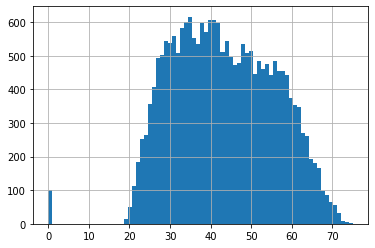

In [21]:
 # распределение клиентов по возрасту
df['dob_years'].hist(bins=76);

Распределение клиентов по возрасту почти равномерное внутри, центр можно разбивать на равные интервалы.

Некорректное значение ноль выделяю в отдельную группу, в данных отсутствуют 18ти летние, но 0й возраст не может соответсвовать этому возрасту, т.к. не впишется в распределение


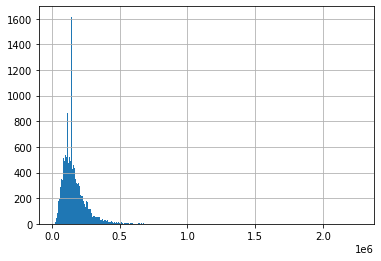

In [22]:
# Распределение клиентов по доходу
df['total_income'].hist(bins=500);

Распределение доходов логнормальное, заполненное медианное значение выбивается. Делю на 8 категорий по процентилям 5, 20, 35, 50, 65, 80, 95, используя данные без пропусков.

In [23]:
purpose_dict = {0: 'жилье/недвижимость', 1: 'автомобиль',  2:'образование', 3:'свадьба', 4:'иное'}
purpose_subcat_dict = {0: '', 1: 'коммерческая',  2:'строительство', 3:'ремонт', 4:'жилая', 11:'подержанный'}
education_dict = dict(df.loc[:,['education_id','education']].drop_duplicates().reset_index(drop=True).to_numpy())
family_dict = dict(df.loc[:,['family_status_id','family_status']].drop_duplicates().reset_index(drop=True).to_numpy())
#gender_dict = {0: 'M', 1: 'F',  2:'XNA'}

dob_years_cat_dict = {0: '0', 1: '18-25', 2: '26-35', 3: '36-45', 4: '46-55', 5: '56-65', 6: '66 и выше'}

total_cat_quantile = [i / 100 for i in [5, 20, 35, 50, 65, 80, 95, 100]]
total_cat_dict={}
for key, value in enumerate(total_cat_quantile):
    total_cat_dict[key] = int(df_without_na['total_income'].quantile(value))
total_cat_dict #границы диапазонов зарплат

{0: 63322,
 1: 94836,
 2: 119370,
 3: 145017,
 4: 175056,
 5: 223107,
 6: 340590,
 7: 2265604}

In [24]:
# Создание функции, возвращающей одну из категорий возраста для каждой строки 
def dob_years_cat(row):
    if row == 0:
        return 0
    elif (row >= 18) & (row <= 25):
        return 1
    elif row <= 35:
        return 2
    elif row <= 45:
        return 3
    elif row <= 55:
        return 4
    elif row <= 65:
        return 5
    else:
        return 6 #Иное


# Добавление столбца категория цели
df.loc[:,'dob_years_category'] = df['dob_years'].apply(dob_years_cat)
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category,purpose_subcategory,dob_years_category
0,1,-8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,0,0,3
1,1,-4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,1,0,3
2,0,-5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,0,0,2
3,3,-4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,2,0,2
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,3,0,4


In [25]:
# Создание функции, возвращающей одну из категорий доходов для каждой строки 
def total_cat(row, cat=total_cat_dict):
    if row <= cat[0]:
        return 0
    elif row <= cat[1]:
        return 1
    elif row <= cat[2]:
        return 2
    elif row <= cat[3]:
        return 3
    elif row <= cat[4]:
        return 4
    elif row <= cat[5]:
        return 5
    elif row <= cat[6]:
        return 6
    else:
        return 7 
    
# Добавление столбца категория цели
df.loc[:,'total_income_category'] = df['total_income'].apply(total_cat)

**Вывод**

Рассмотрено распределение клиентов по возрасту, доходу. Для категоризации возраста выбраны равные интервалы, для дохода выбраны неравные интервалы с примерно равным количеством клиентов в каждом, кроме крайних интервалов. 
Составлены словари для категории данных: Цель, Образование, Семейное положение. Для Цели дополнительно составлен словарь подкатегорий.

### Выводы по предобработке:

**1. Найдены и заполнены пропуски в данных:**

найдены и заполнены пропущенные значения в 2174 строках, отсутствовали значения стажа и дохода. Значения дохода были восстановлены медианными доходами соответсвующих групп занятости. Значения стажа - заполнены уникальным числом.

**2. Преобразованы типы данных:**

выполнена замена типа данных с вещественного на целочисленный для значений стажа и дохода заемщиков.

**3. Найдены и удалены дубликаты:**

осуществлен поиск и удаление явных дубликатов, все дубликаты (54 явных и 17 неявных) содержались среди строк с пропусками. Возможной причиной появления дубликатов является восстановление значений зарплаты одинаковым медианным значением, и отсутствие уникального ID клиента/заявки.

**4. Лемматизированы цели кредита:**

для категоризации целей получения кредита были осуществлена лемматизация формулировок. Что позволило выделить 4 категории целей: 1) жилье и недвижимость, 2) автомобиль, 3) образование, 4) свадьба. Дополнительно были выделены подкатегории недвижимости коммерческая, жилая, ремонт, сторительство и др., а также подкатегория "подержанные" для автомобилей.

**5. Категоризированы данные:**

составлены словари категоризации данных по цели, образованию, семейному положению, возрасту, доходу. Для выделения категорий дохода и возраста были рассмотрены распределения их значений, для возраста выбраны равные интервалы, а для дохода - интервалы с примерно равным количеством значений.


## Шаг 3. Анализ данных

Задачи анализа данных

Необходимо исследовать наличие зависимостей невозвратов

- от количества детей в семье;
- от семейного положения;
- от уровня дохода;
- от категории цели.

Дополнительно можно посмотреть наличие зависимости невозвратов:

- от пола заемщика;
- от возраста заемщика;
- от нескольких параметров сразу. 


### Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [26]:
(df.pivot_table(index='children', values='debt', aggfunc=['count', 'sum', 'mean'])
 .set_axis(['Ко-во клиентов', 'Кол-во невозвратов', 'Доля невозвратов'], axis='columns', inplace=False)
 .rename_axis('Количество детей'))

,Ко-во клиентов,Кол-во невозвратов,Доля невозвратов
Количество детей,,,
0,14091,1063,0.075438
1,4855,445,0.091658
2,2128,202,0.094925
3,330,27,0.081818
4,41,4,0.097561
5,9,0,0.000000


**Вывод**

Исключается из рассмотрения клиентов с 5ю детьми, т.к. слишком маленькое количество клиентов.
Минимальная доля (7,5 %) невозвратов кредита в срок характерна для заемщиков без детей. Максимальная доля невозвратов для заемщиков с 2 и 4 детьми - 9,5 % и 9,8 % соответственно.
Таким образом, выявлена зависимость между количеством детей и возвратом кредита в срок.


### Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [27]:
(df.pivot_table(index='family_status', values='debt', aggfunc=['count', 'sum', 'mean'])
 .set_axis(['Ко-во клиентов', 'Кол-во невозвратов', 'Доля невозвратов'], axis='columns', inplace=False)
 .rename_axis('Семейное положение'))

,Ко-во клиентов,Кол-во невозвратов,Доля невозвратов
Семейное положение,,,
Не женат / не замужем,2810,274,0.097509
в разводе,1195,85,0.071130
вдовец / вдова,959,63,0.065693
гражданский брак,4151,388,0.093471
женат / замужем,12339,931,0.075452


**Вывод**

Выявлена зависимость между семейным положением и возвратом кредита в срок, минимальный невозврат для категории "вдовец / вдова"- 6,6 %, максимальная доля невозвратов для категории "Не женат / не замужем" - 9,8 %.

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [28]:
(df.pivot_table(index='total_income_category', values='debt', aggfunc=['count', 'sum', 'mean'])
 .rename(total_cat_dict).rename_axis('Размер дохода, р. до')
 .set_axis(['Ко-во клиентов', 'Кол-во невозвратов', 'Доля невозвратов'], axis='columns', inplace=False)
)
                  


,Ко-во клиентов,Кол-во невозвратов,Доля невозвратов
"Размер дохода, р. до",,,
63322,968,60,0.061983
94836,2903,249,0.085773
119370,3288,273,0.083029
145017,3973,355,0.089353
175056,3548,297,0.083709
223107,2903,233,0.080262
340590,2902,209,0.072019
2265604,969,65,0.067079


**Вывод**

Есть слабая зависимость между уровнем дохода и возвратом кредита в срок. Минимальный уровень невозвратов наблюдается для клиентов с минимальным (6,2 %) и максимальным (6,7 %) уровнем дохода. Максимальная доля невозвратов для клиентов с доходом чуть меньше медианного - 8,9 %

### Как разные цели кредита влияют на его возврат в срок?

In [29]:
(df.pivot_table(index=['purpose_category', 'purpose_subcategory'], values='debt', aggfunc=['count', 'sum', 'mean'])
 .rename(purpose_dict,level=0).rename(purpose_subcat_dict,level=1).rename_axis(['Категория цели', 'Подкатегория'])
 .set_axis(['Ко-во клиентов', 'Кол-во невозвратов', 'Доля невозвратов'], axis='columns', inplace=False)
)

Ко-во клиентов  Кол-во невозвратов  \
Категория цели     Подкатегория                                        
жилье/недвижимость                          6409                 463   
                   коммерческая             1311                  99   
                   строительство            1878                 144   
                   ремонт                    607                  35   
                   жилая                     606                  41   
автомобиль                                  3828                 367   
                   подержанный               478                  36   
образование                                 4013                 370   
свадьба                                     2324                 186   

                                  Доля невозвратов  
Категория цели     Подкатегория                     
жилье/недвижимость                        0.072242  
                   коммерческая           0.075515  
                   строительство          0.076677  
                   ремонт                 0.057661  
                   жилая                  0.067657  
автомобиль                                0.095873  
                   подержанный            0.075314  
образование                               0.092200  
свадьба                                   0.080034

**Вывод**

Цели кредита также влияют на его возврат в срок. Наилучшие возвраты наблюдаются для кредитов с целью ремонта жилья.
Худшая возвращаемость для категории покупки автомобиля - 9,6 %, при этом для подкатегории подержанных автомобилей возвращаемость больше примерно на 2 %.

### Как пол клиента влияет на возврат в срок кредита

In [30]:
(df.pivot_table(index='gender', values='debt', aggfunc=['count', 'sum', 'mean'])
 .rename_axis('Пол')
 .set_axis(['Ко-во клиентов', 'Кол-во невозвратов', 'Доля невозвратов'], axis='columns', inplace=False))

,Ко-во клиентов,Кол-во невозвратов,Доля невозвратов
Пол,,,
F,14174,994,0.070128
M,7279,747,0.102624
XNA,1,0,0.000000


**Вывод**

Рассмотрено вияние пола клиента на возвращаемость в срок кредита, установлено, что женщины примерно на 3 % лучше возвращают кредиты.

### Как возраст клиента влияет на возврат в срок кредита?

In [31]:
(df.pivot_table(index='dob_years_category', values='debt', aggfunc=['count', 'sum', 'mean'])
 .rename(dob_years_cat_dict).rename_axis('Возраст')
 .set_axis(['Ко-во клиентов', 'Кол-во невозвратов', 'Доля невозвратов'], axis='columns', inplace=False))

,Ко-во клиентов,Кол-во невозвратов,Доля невозвратов
Возраст,,,
0,101,8,0.079208
18-25,1232,131,0.106331
26-35,5351,567,0.105962
36-45,5620,467,0.083096
46-55,4814,328,0.068135
56-65,3634,205,0.056412
66 и выше,702,35,0.049858


**Вывод**

Рассмотрено вияние возраста клиента на возвращаемость в срок кредита, установлено, что с возрастом процент невозвратов сокращается, максимальный процент невозвратов для категории 18-25 лет - 10,6%, а минимальный - для категории 65 и выше составляет 5 %.

### Как меняется статистика невозвратов при группировке данных по 3 параметрам (семейному положению, полу и возрасту)

In [32]:
(df.pivot_table(index=['family_status', 'gender','dob_years_category'], values='debt', aggfunc=['mean','count', 'sum']).
      set_axis(['mean','count', 'sum'], axis='columns', inplace=False).sort_values(by='mean', ascending=False).head(20))

mean  count  sum
family_status         gender dob_years_category                      
вдовец / вдова        M      6                   0.333333      3    1
                             5                   0.260870     23    6
гражданский брак      M      0                   0.200000      5    1
вдовец / вдова        F      0                   0.200000      5    1
в разводе             M      1                   0.200000      5    1
вдовец / вдова        M      4                   0.176471     17    3
в разводе             F      1                   0.176471     17    3
Не женат / не замужем M      3                   0.170213    188   32
                             1                   0.156250    256   40
в разводе             M      2                   0.145455     55    8
Не женат / не замужем M      2                   0.141612    459   65
гражданский брак      M      6                   0.136364     22    3
Не женат / не замужем M      4                   0.135922    103   14
гражданский брак      M      4                   0.130112    269   35
                             3                   0.125348    359   45
                             1                   0.125000    120   15
Не женат / не замужем M      0                   0.125000      8    1
гражданский брак      F      2                   0.114943    696   80
в разводе             F      6                   0.114286     35    4
женат / замужем       F      1                   0.109929    282   31

В узких категориях клиентов процент невозвратов может быть более 20 %, например, для мужчин вдовцов в возрасте 56 лет и выше.
Для задач кредитного скоринга целесообразно увеличить размер выборки и исследовать более узкие группы на предмет высоких рисков невозврата.

## Шаг 4. Общий вывод

Целью проекта является исследование надёжности заёмщиков различных категорий.

**1. В ходе работы был проанализированы исходные данные. В них содержится следующая информация:**

- количество детей в семье
- общий трудовой стаж в днях
- возраст клиента в годах
- уровень образования клиента
- семейное положение
- пол клиента
- тип занятости
- имел ли задолженность по возврату кредитов
- ежемесячный доход
- цель получения кредита

**2. Была выполнена предобработка данных, в том числе:**
- найдены и заполнены пропущенные значения в 2174 строках, отсутствовали значения стажа и дохода. Значения дохода были восстановлены медианными доходами соответсвующих групп занятости. Значения стажа - заполнены уникальным числом. 
- выполнена замена типа данных с вещественного на целочисленный для значений стажа и дохода заемщиков.
- осуществлен поиск и удаление явных дубликатов, все дубликаты (54 явных и 17 неявных) содержались среди строк с пропусками. Возможной причиной появления дубликатов является восстановление значений зарплаты одинаковым медианным значением, и отсутствие уникального ID клиента/заявки.
- для категоризации целей получения кредита были осуществлена лемматизация формулировок. Что позволило выделить 4 категории целей:  1) жилье и недвижимость, 2) автомобиль, 3) образование, 4) свадьба. Дополнительно были выделены подкатегории недвижимости коммерческая, жилая, ремонт, сторительство и др., а также подкатегория "подержанные" для автомобилей.
- составлены словари категоризации данных по цели, образованию, семейному положению, возрасту, доходу. Для выделения категорий дохода и возраста были рассмотрены распределения их значений, для возраста выбраны равные интервалы, а для дохода - интервалы с примерно равным количеством значений. 

**В данных были встречены следующие артефакты:**
- отрицательные значения стажа (может быть вызвано неправильным расчетом стажа, например, вычитание из года начала стажа текущего года),
- слишком большие значения стажа(искажения данных не линейных, восстановление маловероятно), 
- некорректное количество детей -1 и 20 (что может быть вызвано ошибками при введении данных -1 вместо 1, 20 вместо 2),
- нулевой возраст клиентов (значения могут быть частично восстановлены по стажу),
- пол 'XNA', всего одно значение, может быть исключено.

**3. Исследованы и установлены зависимости доли возвратов в срок от различных факторов:**
- от количества детей в семье, изменения от 7,5 % до 9,8 %;
- от семейного положения - от 6,6 % до 9,8 %;
- от уровня дохода - от 6,7 % до 8,9 %;
- от категории цели - от 5,8 % до 9,5 %;
- от пола заемщика - от 7 % до 10,2 %;
- от возраста заемщика - от 5 % до 10,6 %.

Также были рассмотрены более узкие категории и выявлено наличие категорий с высокой долей невозвратов, например, вдовец в возрасте 56 лет и выше имеет более **20 %** невозвратов. Однако для достаточной репрезентативности необходимо увеличить размер выборки, что позволит выявить узкие категории заемщиков с высоким риском невозвратов. 

